# Phase 2: Data Preprocessing

In this notebook, we transform our raw data into a clean, encoded format ready for machine learning. We will use the custom pipeline defined in `src.data_preprocessing`.

### 1. Setup & Imports

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

# Add the project root to system path to import src modules
sys.path.append(os.path.abspath('..'))

from src.data_preprocessing import run_preprocessing_pipeline
from src.config import PROCESSED_DATA_DIR

### 2. Run Preprocessing Pipeline
We call the orchestrator function which handles:
* Cleaning (Missing values, duplicates)
* Outlier Handling (IQR Capping)
* Encoding (One-Hot & Label Encoding)
* Splitting (80/20 Stratified)

In [6]:
# Execute the pipeline
# Ensure the raw CSV is in data/raw/ OR provide the direct path
X_train, X_test, y_train, y_test = run_preprocessing_pipeline('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Loading data from c:\Users\ishfa\datascience\customer-churn-prediction\data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv...
Removed 22 duplicate rows.
Saving processed data...


c:\Users\ishfa\datascience\customer-churn-prediction\src\data_preprocessing.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Data saved to c:\Users\ishfa\datascience\customer-churn-prediction\data\processed
Train shape: (5616, 30)
Test shape: (1405, 30)


### 3. Verification
Let's verify the processed data to ensure everything looks correct before moving to modeling.

In [7]:
# Check shapes
print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

# Check for remaining missing values
print("\nMissing Values in Training Set:", X_train.isnull().sum().sum())

# Preview the features (One-Hot Encoded)
print("\nFirst 5 rows of Training Data:")
display(X_train.head())

# Verify Target Distribution (Stratification check)
print("\nTarget Distribution in Train Set:")
print(y_train.value_counts(normalize=True))

print("\nTarget Distribution in Test Set:")
print(y_test.value_counts(normalize=True))

Training Data: (5616, 30)
Testing Data: (1405, 30)

Missing Values in Training Set: 0

First 5 rows of Training Data:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2629,0,2.0,70.70,140.70,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2650,0,15.0,84.35,1302.65,False,False,False,True,False,True,...,False,False,False,False,False,False,True,True,False,False
1418,0,67.0,89.55,6373.10,True,True,True,True,False,True,...,False,False,False,True,False,False,True,False,False,False
5774,0,5.0,65.60,339.90,True,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
2425,0,26.0,20.30,511.25,True,False,False,True,False,False,...,True,False,True,False,False,False,True,False,True,False



Target Distribution in Train Set:
Churn
0    0.735577
1    0.264423
Name: proportion, dtype: float64

Target Distribution in Test Set:
Churn
0    0.735231
1    0.264769
Name: proportion, dtype: float64


### 4. Correlation Check (Post-Processing)
Now that everything is numeric, we can do a quick check on feature correlations with the target.

C:\Users\ishfa\AppData\Local\Temp\ipykernel_15052\1798392311.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index[:10], y=correlations.values[:10], palette='coolwarm')


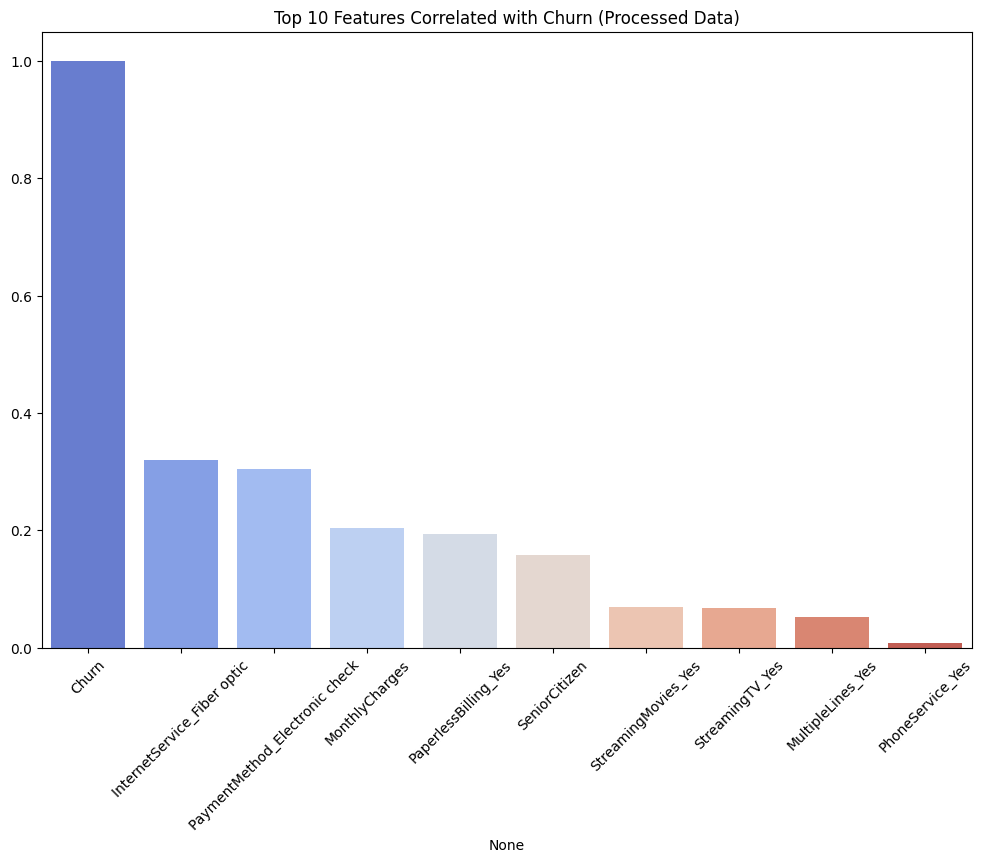

In [8]:
# Combine X_train and y_train for visualization
train_combined = X_train.copy()
train_combined['Churn'] = y_train

plt.figure(figsize=(12, 8))
# Get top 10 features correlated with Churn
correlations = train_combined.corr()['Churn'].sort_values(ascending=False)
sns.barplot(x=correlations.index[:10], y=correlations.values[:10], palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Top 10 Features Correlated with Churn (Processed Data)')
plt.show()

Key Decisions in this Pipeline:
Missing Values (TotalCharges):

Logic: The code coerces errors to NaN and fills them with 0.

Reason: EDA showed these "missing" values are for customers with tenure=0. They haven't been charged yet, so 0 is the mathematically correct replacement.

Outliers (Factor=3.0):

Logic: I used a factor=3.0 (extreme outliers) instead of the standard 1.5.

Reason: In telecom, high usage (high charges) is a valid and important signal. We don't want to aggressively remove your "VIP" customers just because they pay a lot.

One-Hot Encoding (drop_first=True):

Logic: Converts gender to gender_Male and InternetService to InternetService_Fiber optic, InternetService_No.

Reason: drop_first=True reduces multicollinearity (k-1 dummies), which is essential for linear models and harmless for Random Forests.